In [1]:
import pandas as pd
import os
from paths import *
from misc_tools import AudioCut
from misc_my_utils import time_to_frame
import numpy as np
import torch
import pickle

In [2]:
from model_dataset import WordDatasetWordPath as ThisDataset
from model_dataset import WordDictionary
from C_0X_defs import *
# from C_0D_run import load_data_general

In [3]:
valid_guide_path = os.path.join(src_, "guide_validation.csv")
word_rec_dir = train_cut_word_

In [9]:
def get_included_names(loader):
    included_names = []
    for (x, x_lens, word, name) in loader: 
        name = name[0]
        included_names += [name]
    return included_names

In [10]:
def load_data_general(dataset, rec_dir, target_path, load="train", select=0.3, sampled=True, batch_size=BATCH_SIZE):
    # for general, path is easy, let's just load it
    integrated = pd.read_csv(target_path)
    integrated = integrated.sample(frac=1).reset_index(drop=True)

    mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                        n_fft=N_FFT, n_mels=N_MELS, 
                        normalizer=Normalizer.norm_mvn, 
                        denormalizer=DeNormalizer.norm_mvn)
    
    mymap = WordDictionary(os.path.join(src_, "unique_words_list.dict"))

    ds = dataset(rec_dir, 
                        integrated,  
                        mapper=mymap, 
                        transform=mytrans)
    
    use_len = int(select * len(ds))
    remain_len = len(ds) - use_len
    use_ds, remain_ds = random_split(ds, [use_len, remain_len])

    use_shuffle = True if load == "train" else False
    loader = DataLoader(use_ds, batch_size=batch_size, shuffle=use_shuffle, num_workers=LOADER_WORKER, collate_fn=dataset.collate_fn)
    return loader

In [11]:
single_loader = load_data_general(ThisDataset, 
                                    word_rec_dir, valid_guide_path, load="valid", select=0.3, sampled=False, 
                                    batch_size=1)

In [12]:
included_names = get_included_names(single_loader)

In [13]:
included_names

['7447-91187-0037-0041',
 '2989-138028-0026-0015',
 '8609-283227-0066-0038',
 '3830-12531-0023-0017',
 '8419-293469-0004-0039',
 '2182-181173-0029-0008',
 '5678-43303-0033-0016',
 '5867-48852-0076-0015',
 '1743-142913-0014-0035',
 '403-126855-0019-0009',
 '1116-132847-0013-0002',
 '8630-305212-0018-0002',
 '4481-17499-0042-0011',
 '1743-142913-0023-0008',
 '3259-158083-0098-0008',
 '2182-181183-0034-0006',
 '1743-142914-0013-0029',
 '229-130880-0066-0008',
 '8419-286667-0025-0048',
 '8630-305212-0020-0010',
 '3259-158083-0124-0014',
 '4481-17498-0042-0040',
 '103-1241-0001-0017',
 '2691-156750-0019-0010',
 '3830-12531-0001-0016',
 '1743-142912-0014-0009',
 '2691-156755-0012-0025',
 '1743-142913-0014-0041',
 '2007-132570-0006-0003',
 '5678-43303-0035-0006',
 '5678-43301-0003-0031',
 '2182-150130-0007-0024',
 '4297-13009-0006-0023',
 '1116-137572-0048-0025',
 '7447-91187-0050-0004',
 '8419-293469-0016-0031',
 '1116-137572-0037-0001',
 '3830-12530-0001-0001',
 '403-216-0026-0016',
 '1116-

In [15]:
# read in guide file
guide_file = pd.read_csv(valid_guide_path)
# filtering out is not necessary, since we only include wuid for encoded words
guide_file = guide_file[~guide_file["segment_nostress"].isin(["sil", "sp", "spn"])]
filtered_df = guide_file[guide_file['wuid'].isin(included_names)].copy()

filtered_df["startFrame"] = filtered_df.apply(lambda x: time_to_frame(x['startTime'] - x['word_startTime']), axis=1)
filtered_df["endFrame"] = filtered_df.apply(lambda x: time_to_frame(x['endTime'] - x['word_startTime']), axis=1)

In [38]:
guide_file = pd.read_csv(os.path.join(src_, "guide_train.csv"))
guide_file = guide_file[~guide_file["segment_nostress"].isin(["sil", "sp", "spn"])]

In [3]:
deshort = guide_file[guide_file['word_nSample'] > 400]
delong = guide_file[guide_file['word_nSample'] <= 15000]

In [4]:
len(deshort) / len(guide_file)

1.0

In [5]:
len(delong) / len(guide_file)

0.9922523566098395

In [6]:
guide_file.columns

Index(['segment', 'file', 'id', 'startTime', 'endTime', 'nSample', 'word_id',
       'word', 'in_id', 'segment_nostress', 'stress_type', 'phone_path',
       'word_path', 'speaker', 'word_startTime', 'word_endTime',
       'word_nSample', 'wuid'],
      dtype='object')

In [12]:
def create_ground_truth(length, bp_pair):
    # Initialize the ground truth tensor with zeros or a placeholder value
    ground_truth = torch.zeros(length, dtype=torch.int)

    # Start index for the first phoneme
    start_idx = 0

    # Process all but the last phoneme using the boundaries
    for (boundary, phoneme) in bp_pair[:-1]:
        ground_truth[start_idx:boundary] = phoneme
        start_idx = boundary

    # Handle the last phoneme, ensuring it extends to the end of the mel spectrogram if necessary
    ground_truth[start_idx:] = bp_pair[-1][0]

    return ground_truth

In [13]:
class TokenMap: 
    def __init__(self, token_list, starter=1):  
        self.token2idx = {element: index + starter for index, element in enumerate(token_list)}
        self.idx2token = {index + starter: element for index, element in enumerate(token_list)}
    
    def encode(self, token): 
        return self.token2idx[token]
    
    def decode(self, idx): 
        return self.idx2token[idx]
    
    def token_num(self): 
        return len(self.token2idx)

In [39]:
unique_df = guide_file.drop_duplicates(subset='wuid')
word_nSamples_list = ((unique_df['word_nSample'] // 200).astype(int) + 1).tolist()

In [40]:
with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
    mylist = pickle.load(file)

# Now you can use the loaded object
mapper = TokenMap(mylist, starter=0)

In [41]:
grouped = guide_file.groupby('wuid').apply(lambda x: [(mapper.encode(row["segment_nostress"]), time_to_frame(row['endTime'] - row['word_startTime'])) for index, row in x.iterrows()])

In [42]:
i = 0
create_ground_truth(word_nSamples_list[i], grouped[i])

/tmp/ipykernel_391018/3761935688.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  create_ground_truth(word_nSamples_list[i], grouped[i])


tensor([14, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 35, 35, 35, 35, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11], dtype=torch.int32)

In [43]:
mappedgt = [create_ground_truth(word_nSamples_list[i], grouped[i]) for i in range(len(grouped))]

/tmp/ipykernel_391018/587015168.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mappedgt = [create_ground_truth(word_nSamples_list[i], grouped[i]) for i in range(len(grouped))]


In [32]:
modgf = guide_file.copy()

In [33]:
modgf["startFrame"] = modgf.apply(lambda x: time_to_frame(x['startTime'] - x['word_startTime']), axis=1)
modgf["endFrame"] = modgf.apply(lambda x: time_to_frame(x['endTime'] - x['word_startTime']), axis=1)

In [34]:
modgf

,segment,file,id,startTime,endTime,nSample,word_id,word,in_id,segment_nostress,stress_type,phone_path,word_path,speaker,word_startTime,word_endTime,word_nSample,wuid,startFrame,endFrame
3,T,1069-133699-0000,3,0.70,0.79,1440,1.0,took,1.0,T,SNA,1069/133699/0000/1069-133699-0000-0003.flac,1069/133699/0000/1069-133699-0000-0001.flac,1069,0.70,1.02,5120.0,1069-133699-0000-0001,0,7
4,UH1,1069-133699-0000,4,0.79,0.92,2080,1.0,took,2.0,UH,1,1069/133699/0000/1069-133699-0000-0004.flac,1069/133699/0000/1069-133699-0000-0001.flac,1069,0.70,1.02,5120.0,1069-133699-0000-0001,7,17
5,K,1069-133699-0000,5,0.92,1.02,1600,1.0,took,3.0,K,SNA,1069/133699/0000/1069-133699-0000-0005.flac,1069/133699/0000/1069-133699-0000-0001.flac,1069,0.70,1.02,5120.0,1069-133699-0000-0001,17,25
7,AH0,1069-133699-0000,7,1.05,1.16,1760,2.0,a,1.0,AH,0,1069/133699/0000/1069-133699-0000-0007.flac,1069/133699/0000/1069-133699-0000-0002.flac,1069,1.05,1.16,1760.0,1069-133699-0000-0002,0,8
14,AE1,1069-133699-0000,14,1.69,1.81,1920,4.0,after,1.0,AE,1,1069/133699/0000/1069-133699-0000-0014.flac,1069/133699/0000/1069-133699-0000-0004.flac,1069,1.69,2.04,5600.0,1069-133699-0000-0004,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376832,AH0,887-123291-0042,145,14.21,14.27,960,45.0,a,1.0,AH,0,887/123291/0042/887-123291-0042-0145.flac,887/123291/0042/887-123291-0042-0045.flac,887,14.21,14.27,960.0,887-123291-0042-0045,0,4
376833,F,887-123291-0042,146,14.27,14.39,1920,46.0,false,1.0,F,SNA,887/123291/0042/887-123291-0042-0146.flac,887/123291/0042/887-123291-0042-0046.flac,887,14.27,14.58,4960.0,887-123291-0042-0046,0,9
376834,AO1,887-123291-0042,147,14.39,14.48,1440,46.0,false,2.0,AO,1,887/123291/0042/887-123291-0042-0147.flac,887/123291/0042/887-123291-0042-0046.flac,887,14.27,14.58,4960.0,887-123291-0042-0046,9,16
376835,L,887-123291-0042,148,14.48,14.55,1120,46.0,false,3.0,L,SNA,887/123291/0042/887-123291-0042-0148.flac,887/123291/0042/887-123291-0042-0046.flac,887,14.27,14.58,4960.0,887-123291-0042-0046,16,22


In [37]:
selwuid = modgf["wuid"].unique().tolist()

In [52]:
randlist = [np.random.choice(len(selwuid)) for i in range(200)]

In [35]:
sel_phone_df = modgf[modgf["segment_nostress"] == "IY"]

In [61]:
selwuid = modgf["wuid"].unique()[randlist]

In [78]:
selectedgf = modgf[modgf["wuid"].isin(selwuid)]

In [79]:
sel_phone_df = selectedgf[selectedgf["segment_nostress"] == "AH"]

In [80]:
sel_phone_df

,segment,file,id,startTime,endTime,nSample,word_id,word,in_id,segment_nostress,stress_type,phone_path,word_path,speaker,word_startTime,word_endTime,word_nSample,wuid,startFrame,endFrame
5331,AH0,1069-133699-0040,4,0.50,0.57,1120,1.0,was,2.0,AH,0,1069/133699/0040/1069-133699-0040-0004.flac,1069/133699/0040/1069-133699-0040-0001.flac,1069,0.44,0.64,3200.0,1069-133699-0040-0001,4,10
6502,AH0,1069-133699-0048,104,9.88,9.97,1440,26.0,a,1.0,AH,0,1069/133699/0048/1069-133699-0048-0104.flac,1069/133699/0048/1069-133699-0048-0026.flac,1069,9.88,9.97,1440.0,1069-133699-0048-0026,0,7
19009,AH0,118-124588-0010,111,9.14,9.18,640,31.0,a,1.0,AH,0,118/124588/0010/118-124588-0010-0111.flac,118/124588/0010/118-124588-0010-0031.flac,118,9.14,9.18,640.0,118-124588-0010-0031,0,3
22314,AH0,118-47824-0009,42,4.46,4.49,480,11.0,lessens,4.0,AH,0,118/47824/0009/118-47824-0009-0042.flac,118/47824/0009/118-47824-0009-0011.flac,118,4.19,4.58,6240.0,118-47824-0009-0011,21,23
24176,AH0,118-47824-0027,60,4.31,4.35,640,18.0,openly,3.0,AH,0,118/47824/0027/118-47824-0027-0060.flac,118/47824/0027/118-47824-0027-0018.flac,118,4.16,4.48,5120.0,118-47824-0027-0018,11,15
26904,AH1,118-47824-0050,3,0.71,0.75,640,1.0,underbrush,1.0,AH,1,118/47824/0050/118-47824-0050-0003.flac,118/47824/0050/118-47824-0050-0001.flac,118,0.71,1.20,7840.0,118-47824-0050-0001,0,3
26910,AH2,118-47824-0050,9,1.06,1.13,1120,1.0,underbrush,7.0,AH,2,118/47824/0050/118-47824-0050-0009.flac,118/47824/0050/118-47824-0050-0001.flac,118,0.71,1.20,7840.0,118-47824-0050-0001,28,33
44666,AH0,150-132655-0020,14,1.20,1.30,1600,3.0,general,5.0,AH,0,150/132655/0020/150-132655-0020-0014.flac,150/132655/0020/150-132655-0020-0003.flac,150,0.94,1.38,7040.0,150-132655-0020-0003,20,28
51976,AH0,1502-122619-0006,50,4.16,4.20,640,12.0,of,1.0,AH,0,1502/122619/0006/1502-122619-0006-0050.flac,1502/122619/0006/1502-122619-0006-0012.flac,1502,4.16,4.24,1280.0,1502-122619-0006-0012,0,3
56474,AH0,1502-122619-0046,33,2.62,2.70,1280,8.0,a,1.0,AH,0,1502/122619/0046/1502-122619-0046-0033.flac,1502/122619/0046/1502-122619-0046-0008.flac,1502,2.62,2.70,1280.0,1502-122619-0046-0008,0,6


In [7]:
x = np.array([1, 2, 3, 4, 5, 6, 7])
y = [1, 1, 1, 3, 5, 5]

In [8]:
indices = [np.where(x == token)[0][0] for token in y]

In [9]:
indices

[0, 0, 0, 2, 4, 4]

In [49]:
import torchaudio
import torch

'1069/133699/0000/1069-133699-0000-0001.flac'

In [55]:
from model_dataset import Normalizer, DeNormalizer
from model_dataset import MelSpecTransformDB as TheTransform

In [56]:
REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

In [57]:
transform = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                       n_fft=N_FFT, n_mels=N_MELS, 
                       normalizer=Normalizer.norm_mvn, 
                       denormalizer=DeNormalizer.norm_mvn)

In [120]:
cwns = torch.ceil(torch.tensor((guide_file["word_nSample"] / 200).tolist()))

In [124]:
cwns = torch.tensor((guide_file["word_nSample"] // 200 + 1).tolist())

In [125]:
wpl = guide_file["word_path"].tolist()
for i in range(len(wpl)): 
    file_name = os.path.join(
        train_cut_word_, 
        wpl[i]
    )

    data, sample_rate = torchaudio.load(file_name, normalize=True)
    if transform:
        tdata = transform(data)

    if tdata.shape[0] != cwns[i].item(): 
        print(tdata.shape[0], cwns[i].item())

KeyboardInterrupt: 

In [93]:
file_name = os.path.join(
    train_cut_word_, 
    guide_file["word_path"][67]
)

data, sample_rate = torchaudio.load(file_name, normalize=True)
if transform:
    tdata = transform(data)

In [94]:
data.shape, tdata.shape

(torch.Size([1, 2080]), torch.Size([11, 64]))

In [100]:
cwns = torch.ceil(torch.tensor((guide_file["word_nSample"] / 200).tolist()))

In [99]:
cwns.shape, len(guide_file["word_path"].tolist())

(torch.Size([357399]), 357399)

In [ ]:
def create_ground_truth(length, boundaries, phonemes):
    """
    Create a ground truth array for a single mel spectrogram given phoneme boundaries and identifiers,
    ensuring the last phoneme extends to the real length of the spectrogram if necessary.

    Parameters:
    - length: The length of the mel spectrogram in frames (L).
    - boundaries: A numpy array of ending frame indices for each phoneme (N, ).
    - phonemes: A numpy array of phoneme identifiers corresponding to each boundary (N, ).

    Returns:
    - A numpy array of shape (L, ) where each item represents the phoneme identifier for each frame.
    """

    # Initialize the ground truth array with zeros or a placeholder value
    ground_truth = np.zeros(length, dtype=int)

    # Start index for the first phoneme
    start_idx = 0

    # Process all but the last phoneme using the boundaries
    for boundary, phoneme in zip(boundaries[:-1], phonemes[:-1]):
        ground_truth[start_idx:boundary] = phoneme
        start_idx = boundary

    # Handle the last phoneme, ensuring it extends to the end of the mel spectrogram if necessary
    ground_truth[start_idx:] = phonemes[-1]

    return ground_truth.tolist()

In [1]:
import torch
import torch.nn.functional as F

class MaskedCrossEntropyLoss:
    def __init__(self):
        self.loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')  # Use sum to manually control normalization

    def get_loss(self, y_hat, y, mask):
        # Ensure y_hat is of shape (B, C, L)
        y_hat = y_hat.transpose(1, 2)  # Now y_hat is (B, C, L)
        
        # Mask should be applied to sequence lengths
        # No need to expand mask as we are not selecting on the class dimension
        
        # Flatten outputs and targets to apply mask easily
        B, C, L = y_hat.shape
        y_hat_flat = y_hat.reshape(B * L, C)
        y_flat = y.reshape(-1)
        mask_flat = mask.reshape(-1)
        
        # Filter out padded elements
        y_hat_masked = y_hat_flat[mask_flat]
        y_masked = y_flat[mask_flat]

        # Compute the loss
        loss = self.loss_fn(y_hat_masked, y_masked)
        
        # Normalize the loss by the number of non-padded elements
        loss = loss / mask_flat.sum()
        
        return loss


In [2]:
import torch
from torch.nn.functional import one_hot

def test_masked_cross_entropy_loss():
    # Initialize the custom loss
    masked_loss = MaskedCrossEntropyLoss()
    
    # Example parameters
    batch_size = 2
    seq_length = 3
    num_classes = 4
    
    # Create synthetic predictions (y_hat)
    # Let's assume all correct predictions for non-padded values are very confident
    y_hat = torch.tensor([[[0.1, 0.2, 0.7, 0.0], [0.1, 0.7, 0.1, 0.1], [0.7, 0.1, 0.1, 0.1]],  # 1st sample, with last one as padding
                          [[0.1, 0.7, 0.1, 0.1], [0.7, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.7]]]).float()  # 2nd sample, no padding
    y_hat = y_hat.permute(0, 2, 1)  # Correct shape (B, C, L)
    
    # Create synthetic ground truth labels (y)
    y = torch.tensor([[2, 1, 0],  # 0 is a dummy class for padding
                      [1, 0, 3]])
    
    # Create mask (1 for valid, 0 for padding)
    mask = torch.tensor([[1, 1, 0],  # Last element is padding
                         [1, 1, 1]])  # No padding
    
    # Calculate the loss
    loss = masked_loss.get_loss(y_hat, y, mask)
    
    # Expected loss calculation
    # Assuming cross-entropy loss for correctly classified with high confidence is close to 0
    # The padded element should not contribute to the loss
    # So, the expected loss should be very low as only non-padded elements are considered
    print(f"Computed loss: {loss.item()}")
    
    # Check if the loss is as expected (low, indicating padding was ignored)
    assert loss < 0.1, "Loss is higher than expected, indicating padding might not be ignored correctly."

# Run the test case
test_masked_cross_entropy_loss()


Computed loss: 1.469181776046753


AssertionError: Loss is higher than expected, indicating padding might not be ignored correctly.

In [5]:
lsfn = torch.nn.CrossEntropyLoss(reduction='none') 

In [6]:
y_hat = torch.tensor([[[0.1, 0.2, 0.7, 0.0], [0.1, 0.7, 0.1, 0.1], [0.7, 0.1, 0.1, 0.1]],  # 1st sample, with last one as padding
                        [[0.1, 0.7, 0.1, 0.1], [0.7, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.7]]]).float()  # 2nd sample, no padding

In [16]:
y = torch.tensor([[1, 2, 3], [0, 2, 1]])

In [21]:
loss = lsfn(y_hat.permute(0, 2, 1), y)

In [20]:
mask = torch.tensor([[1, 1, 1], [1, 0, 0]])

In [23]:
loss * mask

tensor([[1.4753, 1.5732, 1.5732],
        [1.5732, 0.0000, 0.0000]])

# Randomness in Pytorch

In [1]:
import torch

In [10]:
x = torch.rand((10, )) > 0.1

In [11]:
y = torch.ones((10, 3))

In [15]:
x

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True])

In [16]:
y * x.unsqueeze(-1)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [0., 0., 0.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [17]:
import torch
import torch.nn.functional as F

def enhance_zeros(tensor, C):
    """
    Enhances zeros in a tensor by changing the ones within C elements before and after zeros to zero.

    Args:
    - tensor (torch.Tensor): The input tensor with ones and zeros.
    - C (int): The number of elements before and after zeros to be enhanced to zeros.

    Returns:
    - torch.Tensor: The enhanced tensor.
    """
    # Ensure the tensor is 1D
    if tensor.dim() != 1:
        raise ValueError("Tensor must be 1D. Provided tensor is {}D".format(tensor.dim()))
    
    # Create a convolution kernel
    kernel_size = 2 * C + 1
    kernel = torch.ones((1, 1, kernel_size), dtype=tensor.dtype, device=tensor.device)
    
    # Pad the tensor to handle boundary conditions
    padded_tensor = F.pad(tensor.unsqueeze(0).unsqueeze(0), (C, C), mode='constant', value=1)
    
    # Convolve and threshold
    conv_result = F.conv1d(padded_tensor, kernel)
    enhanced_tensor = (conv_result == kernel_size).float().squeeze()
    
    # Invert to enhance zeros
    enhanced_tensor = 1 - enhanced_tensor
    
    return enhanced_tensor

# Example usage
tensor = torch.tensor([1, 1, 0, 1, 1, 1, 0, 1, 1, 1], dtype=torch.float32)
C = 1  # Number of elements to change before and after zeros
enhanced_tensor = enhance_zeros(tensor, C)

print("Original tensor:", tensor.numpy())
print("Enhanced tensor:", enhanced_tensor.numpy())


Original tensor: [1. 1. 0. 1. 1. 1. 0. 1. 1. 1.]
Enhanced tensor: [0. 1. 1. 1. 0. 1. 1. 1. 0. 0.]


# 20240217

In [1]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

In [16]:
# Sample data: batch of 3 sequences with padding (0s are paddings)
# Lengths need to be provided to pack_padded_sequence so it knows to skip the paddings
data = torch.tensor([[1, 2, 3], [1, 0, 0], [1, 2, 0]]).float()
lengths = torch.tensor([3, 1, 2])  # Actual lengths of sequences without padding

# Define a bidirectional LSTM
lstm = nn.LSTM(input_size=1, hidden_size=2, num_layers=1, batch_first=True, bidirectional=True)

# Process the data using the LSTM
packed_input = pack_padded_sequence(data.unsqueeze(-1), lengths, batch_first=True, enforce_sorted=False)
packed_output, (hidden, cell) = lstm(packed_input)
output, _ = pad_packed_sequence(packed_output, batch_first=True)

# The output tensor gives the output of the LSTM for each sequence at each timestep
# Let's print the output for each sequence at each time step after unpacking
print("Output of the LSTM for each sequence at each timestep:")
print(output)

# Hidden state contains the last hidden state from the LSTM
# For a bidirectional LSTM, it will return two vectors per layer per sequence
# The first is from the forward pass and the second is from the backward pass
print("Last hidden state for each sequence (forward and backward):")
print(hidden)


Output of the LSTM for each sequence at each timestep:
tensor([[[-0.1249, -0.0517, -0.3828, -0.3499],
         [-0.1708, -0.1220, -0.3867, -0.4097],
         [-0.1557, -0.1547, -0.3054, -0.3126]],

        [[-0.1249, -0.0517, -0.2234, -0.1138],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[-0.1249, -0.0517, -0.3500, -0.2470],
         [-0.1708, -0.1220, -0.3123, -0.2289],
         [ 0.0000,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<IndexSelectBackward0>)
Last hidden state for each sequence (forward and backward):
tensor([[[-0.1557, -0.1547],
         [-0.1249, -0.0517],
         [-0.1708, -0.1220]],

        [[-0.3828, -0.3499],
         [-0.2234, -0.1138],
         [-0.3500, -0.2470]]], grad_fn=<IndexSelectBackward0>)


In [2]:
import torch

In [3]:
mu = torch.rand((2, 3, 4))
logvar = torch.rand((2, 3, 4))

In [4]:
mu, logvar

(tensor([[[0.0737, 0.2247, 0.4689, 0.6838],
          [0.5481, 0.5113, 0.4069, 0.1170],
          [0.5956, 0.1688, 0.3862, 0.2856]],
 
         [[0.9135, 0.9221, 0.6875, 0.4926],
          [0.8215, 0.4295, 0.5575, 0.8243],
          [0.8794, 0.0399, 0.9795, 0.6169]]]),
 tensor([[[0.2390, 0.4572, 0.0610, 0.9134],
          [0.7273, 0.2384, 0.2816, 0.9394],
          [0.7865, 0.0481, 0.3904, 0.9297]],
 
         [[0.1654, 0.9366, 0.0739, 0.0950],
          [0.4241, 0.6763, 0.5524, 0.5901],
          [0.7201, 0.7235, 0.5182, 0.9740]]]))

In [5]:
-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

tensor(7.1366)

In [7]:
mu.pow(2) + logvar.exp() - (1 + logvar)

tensor([[[0.0364, 0.1729, 0.2217, 1.0470],
         [0.6426, 0.2923, 0.2092, 0.6328],
         [0.7640, 0.0297, 0.2364, 0.6855]],

        [[0.8489, 1.4649, 0.4754, 0.2473],
         [0.7790, 0.4748, 0.4958, 0.8936],
         [1.1078, 0.3397, 1.1202, 1.0551]]])

In [9]:
dfloss = -0.5 * torch.sum((1 + logvar - mu.pow(2) - logvar.exp()), dim=-1)

In [10]:
dfloss * torch.tensor([[1, 1, 1], [1, 0, 0]])

tensor([[0.7390, 0.8884, 0.8578],
        [1.5183, 0.0000, 0.0000]])

In [24]:
x = torch.tensor([[1, 1, 1], [1, 1, 0], [1, 0, 0]]).bool()
y = torch.tensor([[1, 0, 0], [1, 0, 0], [1, 0, 0]]).float()

In [25]:
z = torch.rand((3, 3))

In [27]:
z

tensor([[0.7061, 0.2096, 0.4580],
        [0.7048, 0.7277, 0.2524],
        [0.2039, 0.6350, 0.1122]])

In [33]:
a = z.masked_select(x)
b = y.masked_select(x)
a, b

(tensor([0.7061, 0.2096, 0.4580, 0.7048, 0.7277, 0.2039]),
 tensor([1., 0., 0., 1., 0., 1.]))

In [39]:
torch.sum(torch.nn.MSELoss(reduction="none")(a, b))

tensor(1.5906)

In [38]:
torch.sum(torch.nn.MSELoss(reduction="none")(z, y) * x)

tensor(1.5906)

# VQ try

In [2]:
import torch

In [3]:
embedding = torch.rand((10, 3))
ze = torch.rand((2, 5, 3))

In [4]:
B, L, C = ze.shape
K, _ = embedding.shape

In [5]:
embedding_broadcast = embedding.reshape(1, 1, K, C)
ze_broadcast = ze.reshape(B, L, 1, C)

In [6]:
distance = torch.sum((embedding_broadcast - ze_broadcast)**2, -1)

In [7]:
distance.shape

torch.Size([2, 5, 10])

In [12]:
nearest_neighbor = torch.argmin(distance, 2)

In [13]:
nearest_neighbor.shape

torch.Size([2, 5])

# Cross Attention

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ScaledDotProductAttention(nn.Module):
    def __init__(self, q_in, kv_in, qk_out, v_out):
        super(ScaledDotProductAttention, self).__init__()
        self.w_q = nn.Linear(q_in, qk_out)
        self.w_k = nn.Linear(kv_in, qk_out)
        self.w_v = nn.Linear(kv_in, v_out)
        self.d_k = qk_out

    def forward(self, q, k, v, mask=None):
        """
        q: Query tensor of shape (batch_size, num_queries, d_k)
        k: Key tensor of shape (batch_size, num_keys, d_k)
        v: Value tensor of shape (batch_size, num_values, d_v), num_keys = num_values
        mask: Mask tensor of shape (batch_size, num_queries, num_keys)

        Returns: Output tensor of shape (batch_size, num_queries, d_v)
        """
        q = self.w_q(q)
        k = self.w_k(k)
        v = self.w_v(v)

        # Step 1: Compute the dot product between queries and keys
        attn_scores = torch.bmm(q, k.transpose(1, 2))  # (batch_size, num_queries, num_keys)

        # Step 2: Scale the attention scores
        attn_scores = attn_scores / (self.d_k ** 0.5)

        # Step 3: Apply the mask (if any)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float("-inf"))

        # Step 4: Compute the softmax of the attention scores
        attn_weights = F.softmax(attn_scores, dim=-1)  # (batch_size, num_queries, num_keys)

        # Step 5: Multiply the attention weights with the values
        output = torch.bmm(attn_weights, v)  # (batch_size, num_queries, d_v)

        return output, attn_weights

In [71]:
from model_padding import generate_mask_from_lengths_mat

In [72]:
device = torch.device('cpu')

In [73]:
a = torch.rand((3, 4, 5))
b = torch.rand((3, 4, 5))

In [74]:
attn = ScaledDotProductAttention(5, 5, 5, 5)

In [75]:
x_mask = generate_mask_from_lengths_mat([2, 3, 4], device=device)

In [84]:
x, y = attn(a, b, b)

In [85]:
x.shape, y.shape

(torch.Size([3, 4, 5]), torch.Size([3, 4, 4]))

In [86]:
x

tensor([[[-0.4752, -0.6958,  0.4442,  0.0080, -0.4331],
         [-0.4717, -0.6864,  0.4356,  0.0099, -0.4285],
         [-0.4733, -0.6913,  0.4403,  0.0092, -0.4320],
         [-0.4741, -0.6913,  0.4402,  0.0093, -0.4315]],

        [[-0.6807, -0.7565,  0.6334,  0.0301, -0.7380],
         [-0.6827, -0.7599,  0.6362,  0.0303, -0.7418],
         [-0.6793, -0.7551,  0.6322,  0.0298, -0.7364],
         [-0.6759, -0.7555,  0.6323,  0.0285, -0.7371]],

        [[-0.4857, -0.7882,  0.6660, -0.0513, -0.5572],
         [-0.4922, -0.7798,  0.6610, -0.0470, -0.5570],
         [-0.4834, -0.7906,  0.6673, -0.0526, -0.5570],
         [-0.4850, -0.7890,  0.6665, -0.0517, -0.5572]]],
       grad_fn=<BmmBackward0>)

In [83]:
F.scaled_dot_product_attention(a, b, b)

tensor([[[0.4774, 0.5495, 0.3095, 0.4692, 0.3498],
         [0.4660, 0.5203, 0.3253, 0.4569, 0.3365],
         [0.4549, 0.5480, 0.3197, 0.4356, 0.3377],
         [0.4669, 0.5410, 0.3170, 0.4562, 0.3428]],

        [[0.4735, 0.6425, 0.8228, 0.6482, 0.5196],
         [0.4775, 0.6498, 0.8231, 0.6443, 0.5269],
         [0.4730, 0.6402, 0.8223, 0.6422, 0.5118],
         [0.4807, 0.6535, 0.8225, 0.6332, 0.5262]],

        [[0.6013, 0.8321, 0.3478, 0.6847, 0.2792],
         [0.5861, 0.8205, 0.3884, 0.6765, 0.2755],
         [0.6131, 0.8372, 0.3385, 0.6878, 0.2838],
         [0.6081, 0.8347, 0.3449, 0.6851, 0.2826]]])

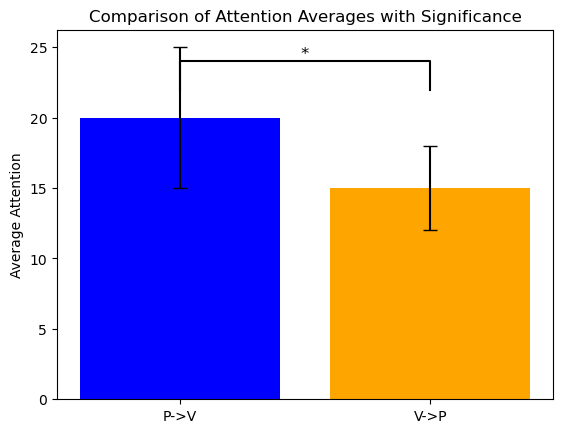

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Sample means and standard deviations for demonstration purposes
means = [20, 15]  # Replace with your actual data
stddevs = [5, 3]  # Replace with your actual data
labels = ['P->V', 'V->P']

fig, ax = plt.subplots()

# Drawing the bars
bars = ax.bar(labels, means, yerr=stddevs, capsize=5, color=['blue', 'orange'])

# Coordinates for the significance line
x1, x2 = 0, 1  # Bar positions on the x-axis
y, h, col = max(means) + 2, 2, 'black'  # Line height, line width, and color

# Drawing the significance line
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# Adding the significance stars
ax.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col, fontsize=12)

# Add other plot details
ax.set_ylabel('Average Attention')
ax.set_title('Comparison of Attention Averages with Significance')

plt.show()


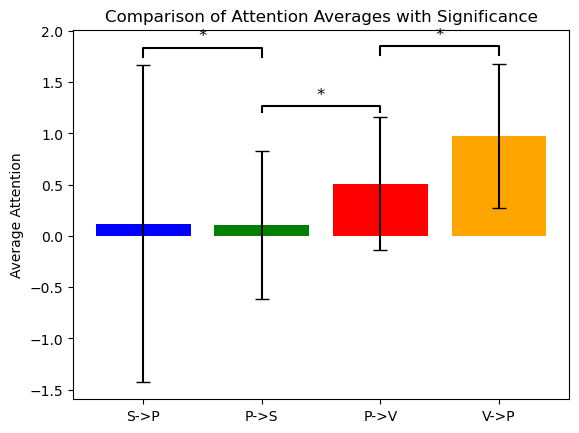

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming means and SEMs are already calculated and p_values contain the p-values for the comparisons
use_labels = ['S->P', 'P->S', 'P->V', 'V->P']
means = [np.random.rand() for _ in range(4)]  # Replace with actual means
sems = [np.random.rand() for _ in range(4)]  # Replace with actual SEMs
use_colors = ['blue', 'green', 'red', 'orange']
p_values = [0.04, 0.03, 0.04]  # Example p-values, replace with actual p-values
significance_threshold = 0.05
signif_positions_pairs = [(0, 1), (1, 2), (2, 3)]  # Pairs of positions for each comparison

fig, ax = plt.subplots()

# Drawing the bars
x = np.arange(len(use_labels))  # Label locations
bars = ax.bar(x, means, yerr=1.96*np.array(sems), capsize=5, color=use_colors)

# Adding significance annotations
for (pos1, pos2), p_val in zip(signif_positions_pairs, p_values):
    if p_val < significance_threshold:
        # Draw lines
        y_max = max(means[pos1] + 1.96*sems[pos1], means[pos2] + 1.96*sems[pos2])
        h = y_max * 0.05  # 5% above the max for drawing the line
        ax.plot([pos1, pos1, pos2, pos2], [y_max + h, y_max + 2*h, y_max + 2*h, y_max + h], lw=1.5, c='black')
        
        # Annotate significance
        ax.text((pos1 + pos2) / 2, y_max + 2.5*h, '*', ha='center', va='bottom', color='black', fontsize=12)

# Add other plot details
ax.set_xticks(x)
ax.set_xticklabels(use_labels)
ax.set_ylabel('Average Attention')
ax.set_title('Comparison of Attention Averages with Significance')

plt.show()


In [3]:
learned_runs = [1, 3, 4]
learned_runs = [str(num) for num in learned_runs]
string_learned_runs = "".join(learned_runs)
string_learned_runs

'134'

In [6]:
import pandas as pd

# Example DataFrame
data = {
    'id': [1, 2, 3, 4, 5],
    'name': ['Alice', 'Bob', 'Carol', 'David', 'Eve']
}
df = pd.DataFrame(data)

# Your list of IDs, with duplicates
ids_of_interest = [2, 2, 2, 3, 3, 5]

# Create a DataFrame from your list of IDs
ids_df = pd.DataFrame(ids_of_interest, columns=['id'])["id"]

id_to_name = pd.Series(df['name'].values, index=df["id"])
names = list(map(id_to_name.get, ids_df))
ids_df.map(id_to_name).tolist()
# print(names)


['Bob', 'Bob', 'Bob', 'Carol', 'Carol', 'Eve']

In [9]:
import torch

# Create example tensors
tensor_a = torch.randn(3, 4)  # Tensor A with shape (B, D) where B=3 and D=4
tensor_b = torch.randn(3, 2, 4)  # Tensor B with shape (B, L, D) where B=3, L=2, D=4

# Reshape tensor A from (B, D) to (B, 1, D)
tensor_a_reshaped = tensor_a.unsqueeze(1).repeat_interleave(2, dim=-2)

# Concatenate tensor_a_reshaped with tensor_b along the second dimension (dim=1)
result_tensor = torch.cat((tensor_a_reshaped, tensor_b), dim=-1)

# Check the shape of the resulting tensor
print("Shape of the resulting tensor:", result_tensor.shape)


Shape of the resulting tensor: torch.Size([3, 2, 8])
